In [232]:
# Import required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import plotly.graph_objs as go
from collections import defaultdict

In [105]:
# Function to create unified dataset
def read_files():
    files = ['dataset/file_3_Mar18_Output_1_1.csv', 
             'dataset/file_3_Mar18_Output_1_2.csv', 
             'dataset/file_3_Mar18_Output_1_3.csv', 
             'dataset/file_3_Mar18_Output_1_4.csv', 
             'dataset/file_3_Mar18_Output_1_5.csv', 
             'dataset/file_3_Mar18_Output_1_6.csv', 
             'dataset/file_4_Mar18_Output_1_1.csv', 
             'dataset/file_4_Mar18_Output_1_2.csv', 
             'dataset/file_4_Mar18_Output_1_3.csv', 
             'dataset/file_4_Mar18_Output_1_4.csv', 
             'dataset/file_4_Mar18_Output_1_5.csv', 
             'dataset/file_4_Mar18_Output_1_6.csv']
    data = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        data = pd.concat([data, df])
    return data

In [106]:
# Import main dataset
data = read_files()

In [107]:
# Import data dictionary to map 'mos' column
xl = pd.ExcelFile('dataset/U of I IVR code data dictionary(updated).xlsx')
mos_sheet = xl.parse('mos')
mos_sheet.head()

,Code,IVR Call Reason for IVR Call Reporting
0,AA,Activation
1,AG,Transferred from agent
2,AL,Account lookup
3,AP,Address phone change
4,AR,APR Information


In [108]:
# Visualize 'mos' column of dataset
data['mos'].head()

0                IA PP TR
1          IA BA TS nl TR
2    IA AA BA MR nl PT TR
3                   IA BA
4       IA BA TS nl mm TR
Name: mos, dtype: object

In [109]:
# Parsing and Mapping the MOS values
mos_mapping = dict(zip(mos_sheet['Code'], mos_sheet['IVR Call Reason for IVR Call Reporting']))

def map_codes_to_descriptions(code_sequence):
    codes = code_sequence.split()  # Split the sequence into individual codes
    descriptions = [mos_mapping.get(code, "Unknown") for code in codes]  # Map each code to its description
    return descriptions


# Create additional column to include descriptions in the main dataset
data['mos_descriptions'] = data['mos'].apply(map_codes_to_descriptions)
data[['mos', 'mos_descriptions']].head()

,mos,mos_descriptions
0,IA PP TR,"[Identification and authentication, PBP Predic..."
1,IA BA TS nl TR,"[Identification and authentication, Account Su..."
2,IA AA BA MR nl PT TR,"[Identification and authentication, Activation..."
3,IA BA,"[Identification and authentication, Account Su..."
4,IA BA TS nl mm TR,"[Identification and authentication, Account Su..."


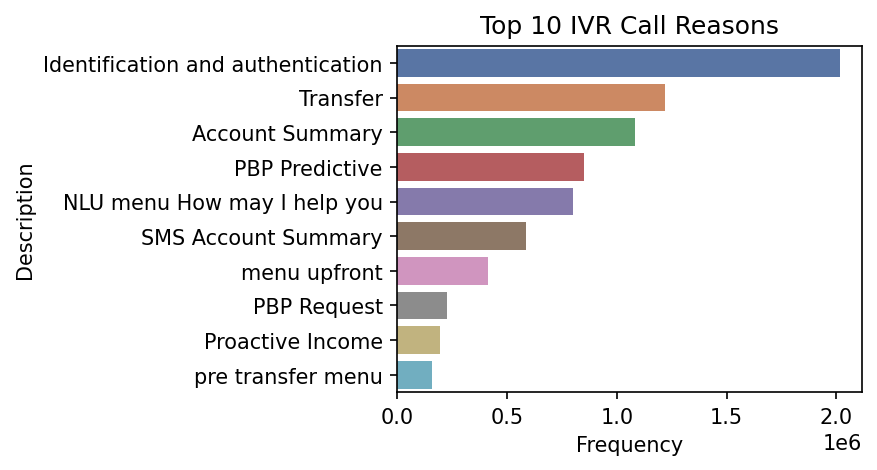

,Description,Frequency
0,Identification and authentication,2017281
2,Transfer,1219242
3,Account Summary,1084149
1,PBP Predictive,849832
5,NLU menu How may I help you,800678
4,SMS Account Summary,585427
16,menu upfront,411732
7,PBP Request,224529
14,Proactive Income,193155
10,pre transfer menu,155707


In [111]:
# Frequency Analysis of Most common Tags
list_descriptions = [item for sublist in data['mos_descriptions'].tolist() for item in sublist]
description_frequencies = Counter(list_descriptions)
df_frequencies = pd.DataFrame(description_frequencies.items(), columns=['Description', 'Frequency']).sort_values(by='Frequency', ascending=False)

# plot df_frequencies
plt.figure(figsize=(4, 3), dpi=150)
sns.barplot(x='Frequency', y='Description', data=df_frequencies.head(10), palette='deep')
plt.title('Top 10 IVR Call Reasons')
plt.show()

df_frequencies.head(10)

### **First Step: Filtering Calls that End with TRANSFER**

In [113]:
data['account_open_date_13_march'] = pd.to_datetime(data['account_open_date_13_march'], errors='coerce')
data['account_open_date_18_march'] = pd.to_datetime(data['account_open_date_18_march'], errors='coerce')
data['account_age_years'] = data['account_open_date_13_march'].apply(lambda x: (current_analysis_date - x).days / 365.25)

TR_df = data[data['mos'].str.endswith('TR')]
TR_df.info(), TR_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203551 entries, 0 to 144164
Data columns (total 26 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   timestamp_call_key                 1203551 non-null  object        
 1   retailer_code                      1203551 non-null  object        
 2   serial                             1203551 non-null  int64         
 3   reason                             1203551 non-null  object        
 4   mos                                1203551 non-null  object        
 5   resolved                           1203551 non-null  object        
 6   no_of_accounts_with_syf_13_march   1200746 non-null  float64       
 7   account_balance_13_march           1132210 non-null  float64       
 8   delinquency_history_13_march       1203551 non-null  object        
 9   account_open_date_13_march         1203551 non-null  datetime64[ns]
 10  account

(None,
       timestamp_call_key retailer_code       serial reason  \
 0  240315173250 DAL1OA3M             D  10010009499     PP   
 1  240315124742 DAL15XHK             E  10006021998     BA   
 2  240317114237 DAL3BLK6             J  10016007830     PT   
 4  240314145902 DAL68RYS             I  10013002037     BA   
 5  240314151323 PHX4I30S             I  10013002037     PS   
 
                           mos  resolved  no_of_accounts_with_syf_13_march  \
 0                    IA PP TR  resolved                               1.0   
 1              IA BA TS nl TR     floor                               2.0   
 2        IA AA BA MR nl PT TR  resolved                              12.0   
 4           IA BA TS nl mm TR     floor                               6.0   
 5  IA BA TS nl PS nl mt RS TR     floor                               6.0   
 
    account_balance_13_march delinquency_history_13_march  \
 0                       NaN                         [00]   
 1                   

In [114]:
numerical_cols = ['no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march', 'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march', 'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march']
numerical_correlations = TR_df[numerical_cols].corr(method='spearman')

contingency_table = pd.crosstab(data['resolved'], data['mos'].str.endswith('TR'))
chi2, p, dof, expected = chi2_contingency(contingency_table)

numerical_correlations, contingency_table, p


(                                   no_of_accounts_with_syf_13_march  \
 no_of_accounts_with_syf_13_march                           1.000000   
 account_balance_13_march                                  -0.005983   
 eservice_ind_13_march                                      0.032919   
 auto_pay_enrolled_status_13_march                          0.008939   
 no_of_accounts_with_syf_18_march                           0.999063   
 account_balance_18_march                                  -0.005090   
 eservice_ind_18_march                                      0.030012   
 auto_pay_enrolled_status_18_march                          0.008210   
 
                                    account_balance_13_march  \
 no_of_accounts_with_syf_13_march                  -0.005983   
 account_balance_13_march                           1.000000   
 eservice_ind_13_march                             -0.051448   
 auto_pay_enrolled_status_13_march                  0.024816   
 no_of_accounts_with_syf_18_ma

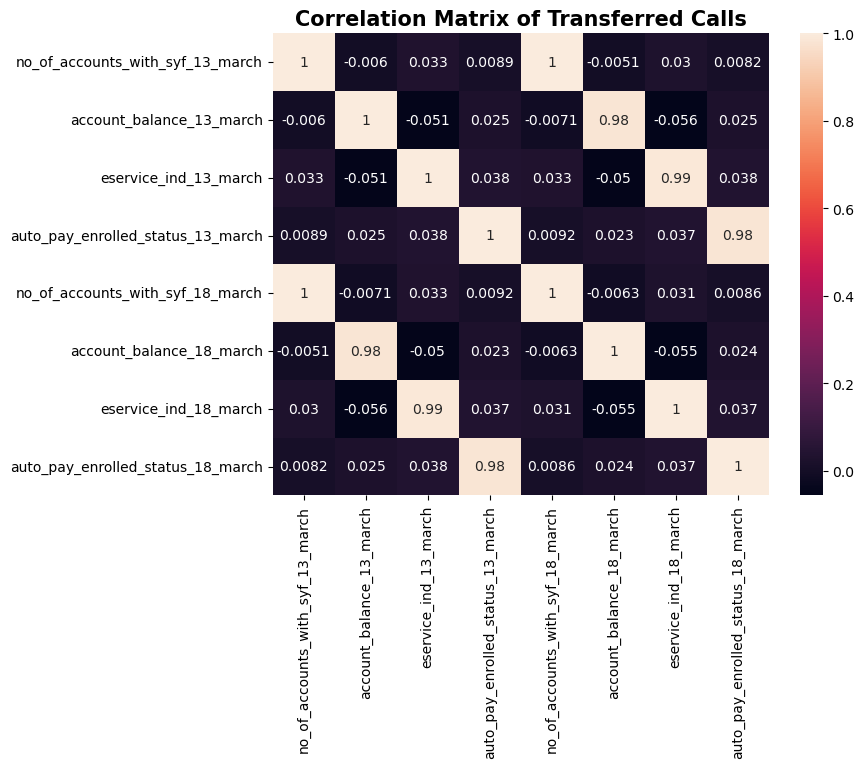

In [117]:
# Help me visualize those numerical correlations
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(numerical_correlations, annot=True)
plt.title('Correlation Matrix of Transferred Calls', fontweight='bold', fontsize=15)
plt.show()


- People with several accounts gets transferred more frequently than others.
- People with an account balance are more likely to be transferred.

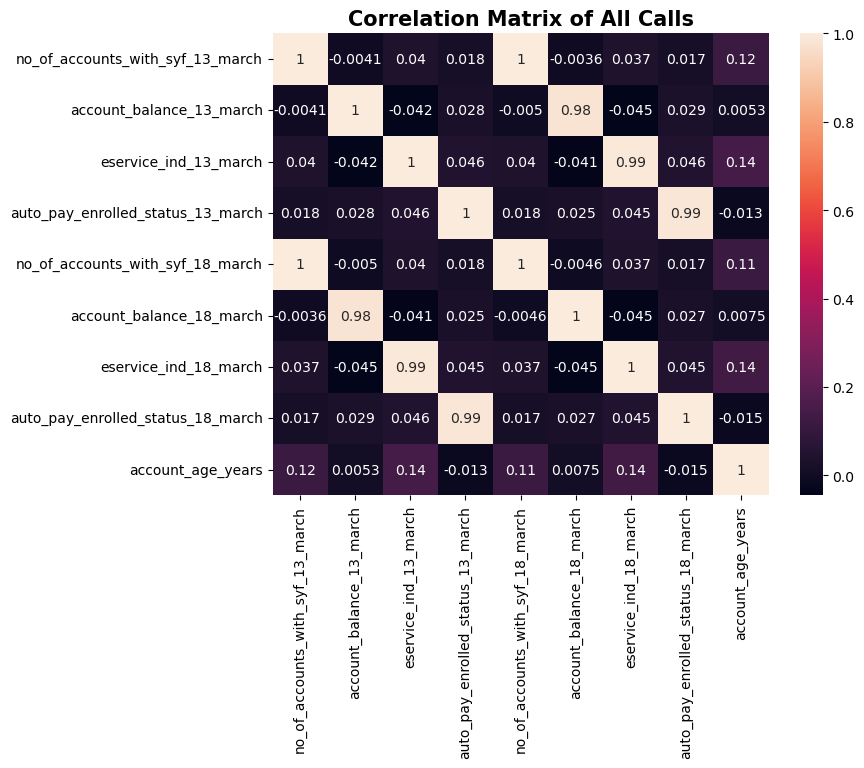

In [118]:
# Create a correlation matrix using the data df for all the variables that are numerical
numerical_cols = ['no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march', 'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march', 'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march', 'account_age_years']
numerical_correlations = data[numerical_cols].corr(method='spearman')

# Help me visualize those numerical correlations
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(numerical_correlations, annot=True)
plt.title('Correlation Matrix of All Calls', fontweight='bold', fontsize=15)
plt.show()

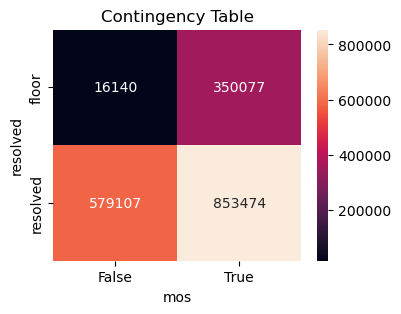

In [119]:
# Help me visualize the contingency table
plt.figure(figsize=(4, 3), dpi=100)
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title('Contingency Table')
plt.show()

## **Initial Insights**

In [120]:
# Clean Dataset

attributes_of_interest = [
    'eservice_ind_13_march', 
    'no_of_accounts_with_syf_13_march', 
    'account_age_years',
    'card_activation_status_13_march',
    'account_balance_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'auto_pay_enrolled_status_13_march',
    'delinquency_history_13_march'
]

non_numeric_attributes = [
    'card_activation_status_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'delinquency_history_13_march'
]

# Display unique values for these non-numeric attributes to understand their categories
non_numeric_values = {attribute: TR_df[attribute].unique() for attribute in non_numeric_attributes}
non_numeric_values


{'card_activation_status_13_march': array(['0', '8', '7', ' '], dtype=object),
 'account_status_13_march': array([nan, 'F', 'E', 'A', 'Z', 'I', 'C', 'L', 'U', 'B'], dtype=object),
 'ebill_enrolled_status_13_march': array(['E', ' ', 'L', 'B', nan, 'D'], dtype=object),
 'delinquency_history_13_march': array(['[00]', '[03]', '[20]', '[02]', '[22]', '[32]', '[43]', '[54]',
        '[76]', '[23]', '[08]', '[88]', '[05]', '[56]', '[04]', '[06]',
        '[33]', '[65]', '[35]', '[07]', '[48]', '[24]', '[87]', '[44]',
        '[34]', '[55]', '[46]', '[47]', '[66]', '[25]', '[26]', '[30]',
        '[58]', '[37]', '[68]', '[57]', '[45]', '[36]', '[77]', '[67]',
        '[78]', '[27]', '[40]', '[53]', '[42]'], dtype=object)}

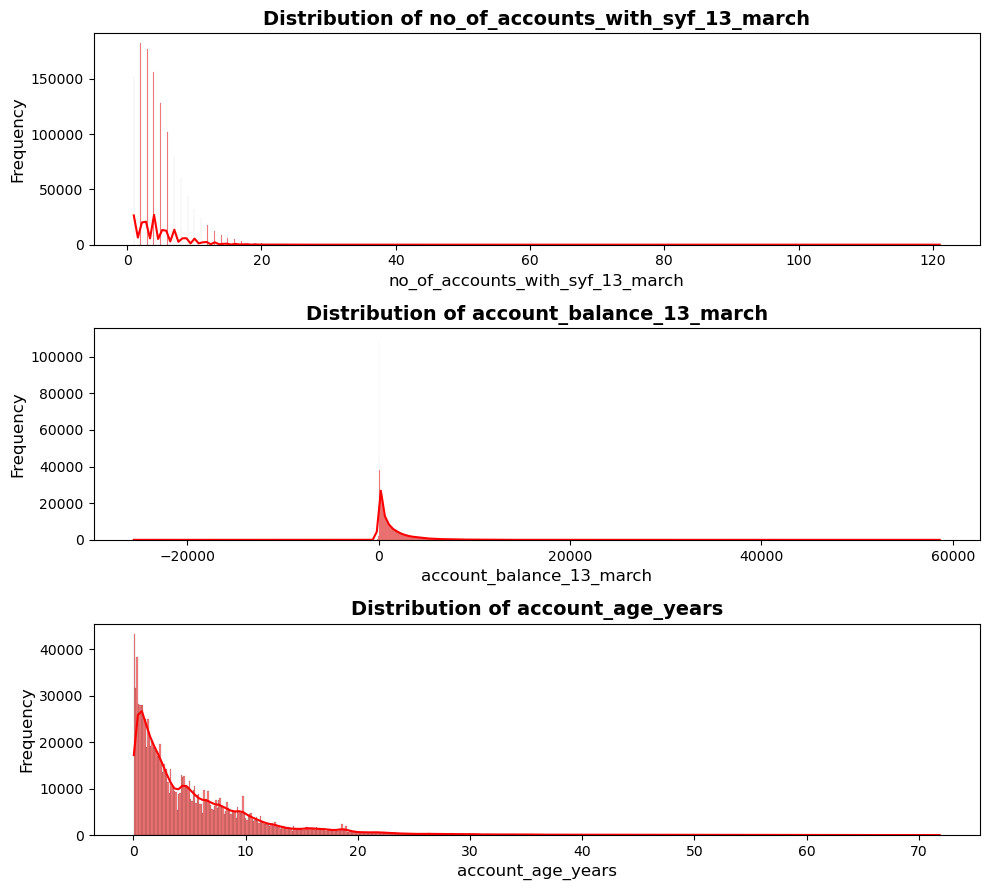

In [122]:
# Define continuous and categorical attributes after encoding.
continuous_attributes = [
    'no_of_accounts_with_syf_13_march', 
    'account_balance_13_march', 
    'account_age_years'
]

categorical_attributes_encoded = [
    attribute + '_encoded' for attribute in non_numeric_attributes
]

# Visualize continuous attributes with distribution plots.
fig, axes = plt.subplots(nrows=len(continuous_attributes), ncols=1, figsize=(10, 3 * len(continuous_attributes)), dpi=100)
for i, attribute in enumerate(continuous_attributes):
    sns.histplot(TR_df[attribute], kde=True, ax=axes[i], color='red')
    axes[i].set_title(f'Distribution of {attribute}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(attribute, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [123]:
label_encoder = LabelEncoder()
encoded_TR = TR_df[non_numeric_attributes].copy()
encoded_data = data[non_numeric_attributes].copy()


for attribute in non_numeric_attributes:
    # Fill NaN with a string to indicate missing data
    encoded_TR[attribute] = encoded_TR[attribute].fillna('Missing')
    encoded_data[attribute] = encoded_data[attribute].fillna('Missing')
    # Replace empty spaces with a string to indicate missing data
    encoded_TR[attribute] = encoded_TR[attribute].replace(' ', 'Missing')
    encoded_data[attribute] = encoded_data[attribute].replace(' ', 'Missing')
    # Apply label encoding
    encoded_TR[attribute] = label_encoder.fit_transform(encoded_TR[attribute])
    encoded_data[attribute] = label_encoder.fit_transform(encoded_data[attribute])

# Merge the encoded attributes back into the original DataFrame
for attribute in non_numeric_attributes:
    TR_df[attribute + '_encoded'] = encoded_TR[attribute]
    data[attribute + '_encoded'] = encoded_data[attribute]

c:\Users\johan\anaconda3\envs\alfa\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


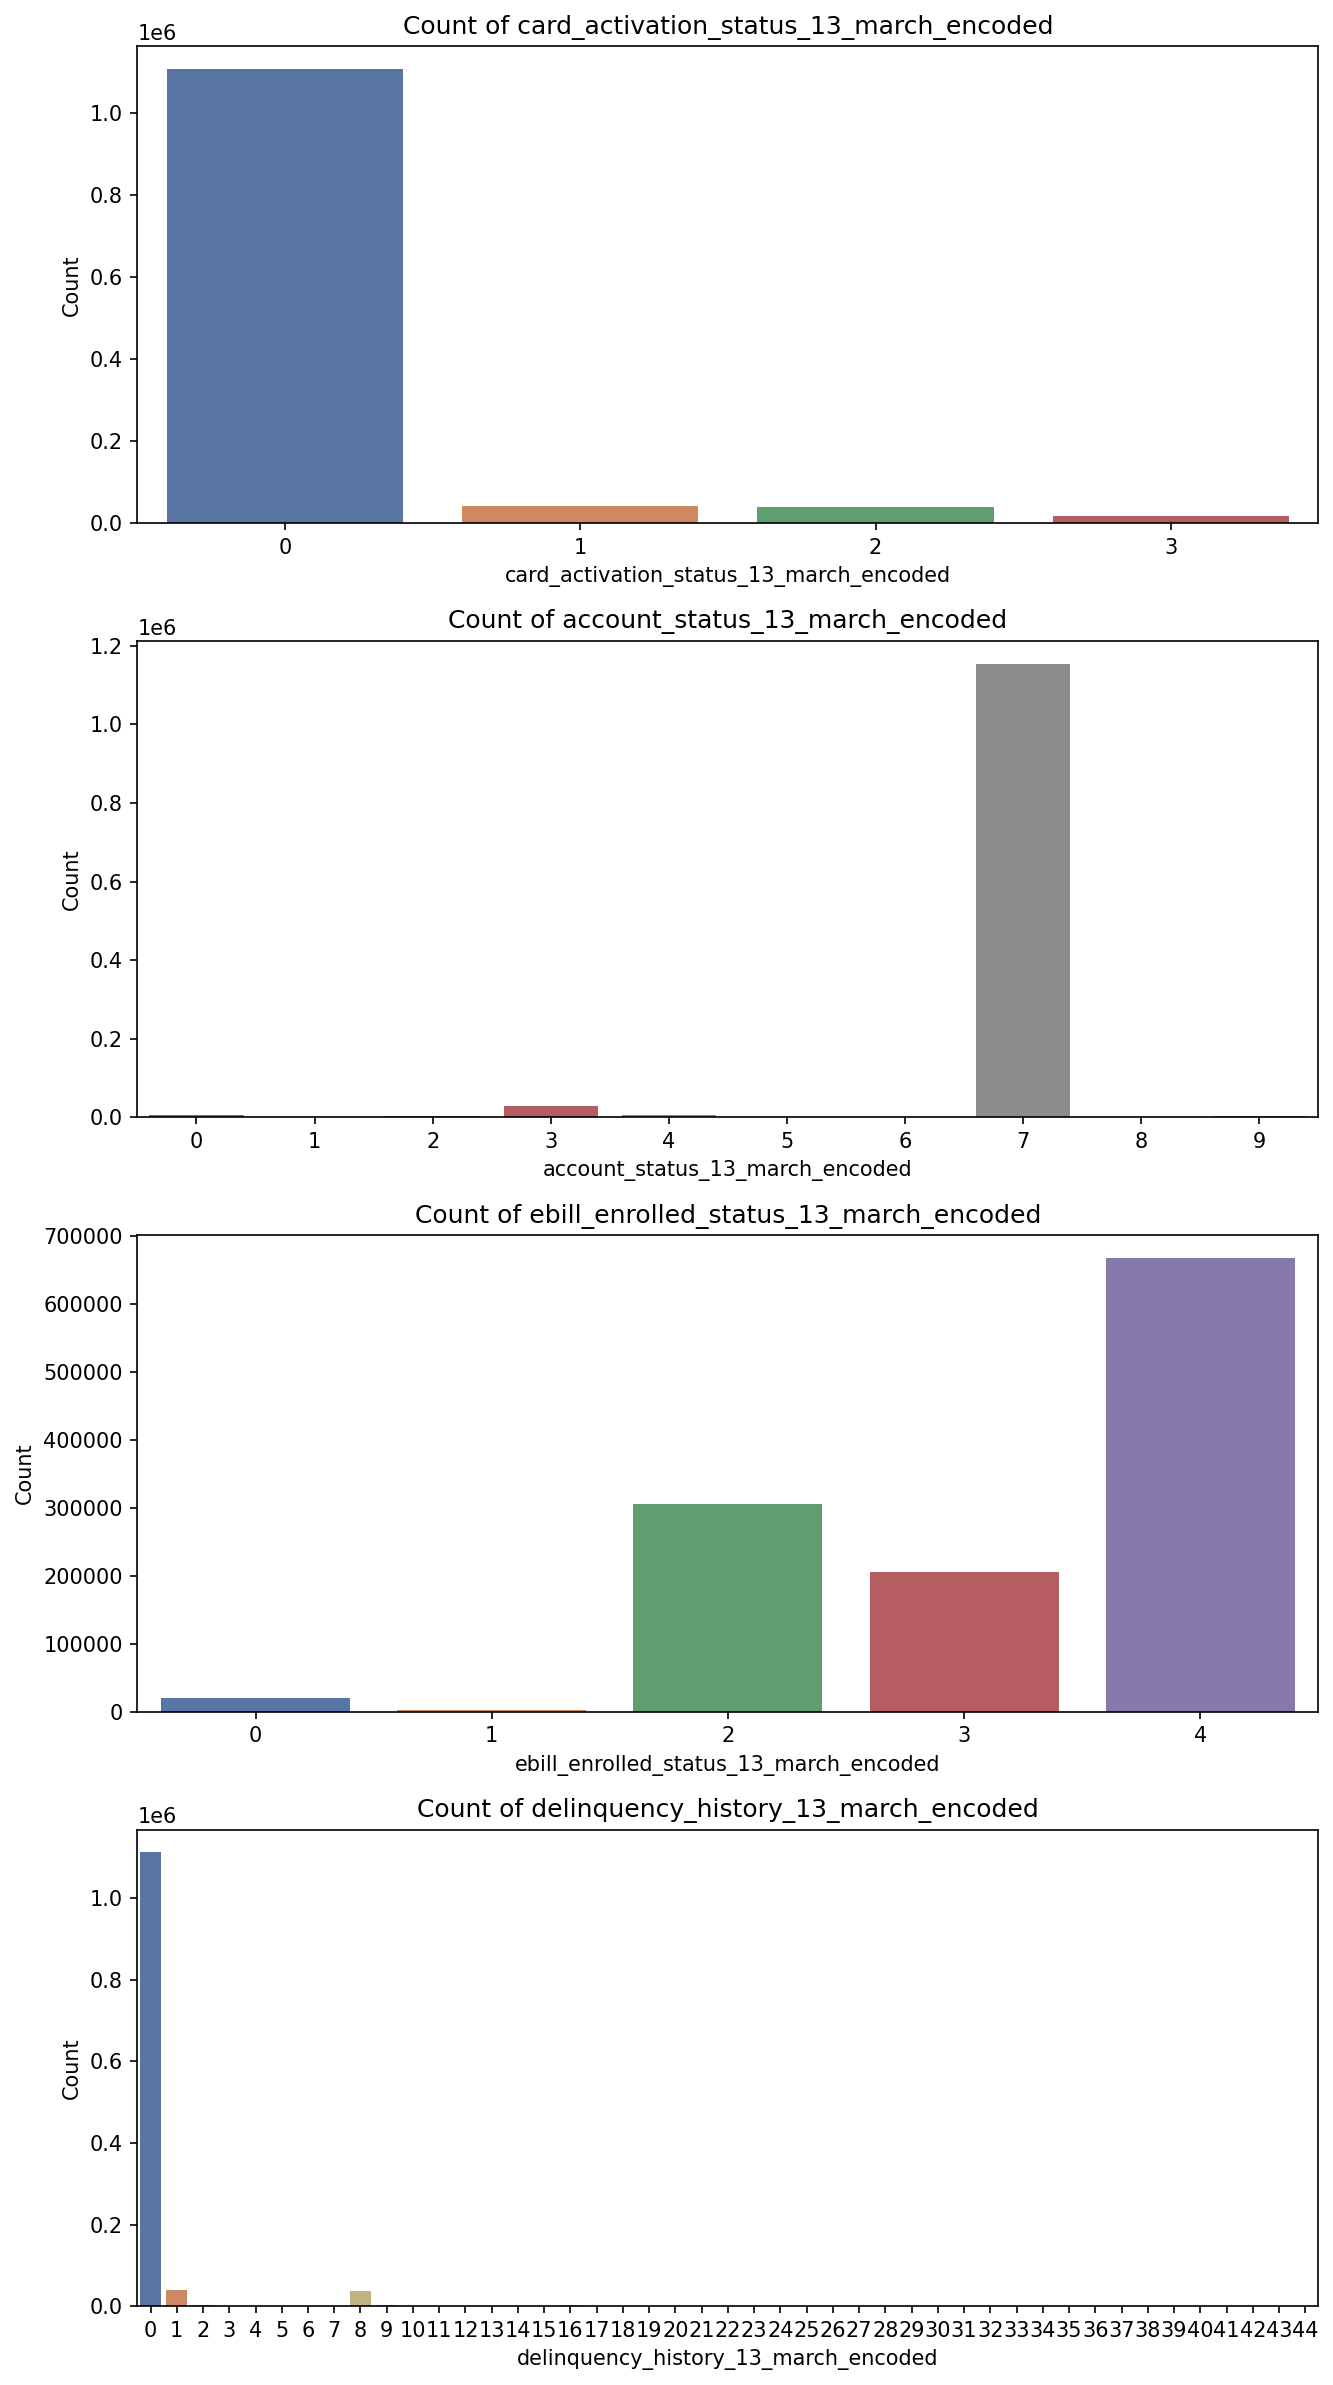

In [130]:
# Visualize categorical attributes with count plots.
fig, axes = plt.subplots(nrows=len(categorical_attributes_encoded), ncols=1, figsize=(9, 4 * len(categorical_attributes_encoded)), dpi=150)
for i, attribute in enumerate(categorical_attributes_encoded):
    sns.countplot(x=TR_df[attribute], ax=axes[i], palette='deep')
    axes[i].set_title(f'Count of {attribute}', fontsize=12)
    axes[i].set_xlabel(attribute, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
plt.tight_layout()
plt.show()

In [128]:
# Show a sample of the encoded categorical attributes
TR_df[categorical_attributes_encoded].sample(10)

,card_activation_status_13_march_encoded,account_status_13_march_encoded,ebill_enrolled_status_13_march_encoded,delinquency_history_13_march_encoded
116542,0,7,4,0
36723,0,7,4,0
84100,0,7,3,1
140412,0,7,2,0
139668,0,7,2,0
9035,0,7,4,0
148949,0,7,4,0
51831,0,7,4,1
18761,0,7,3,0
80035,0,7,3,0


In [129]:
data['mos'].str.endswith('TR').value_counts()

True     1203551
False     595247
Name: mos, dtype: int64

In [133]:
chi2_results = {}
for attribute in categorical_attributes_encoded:
    contingency_table = pd.crosstab(data[attribute], data['mos'].str.endswith('TR'))
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[attribute] = {'chi2': chi2, 'p-value': p}

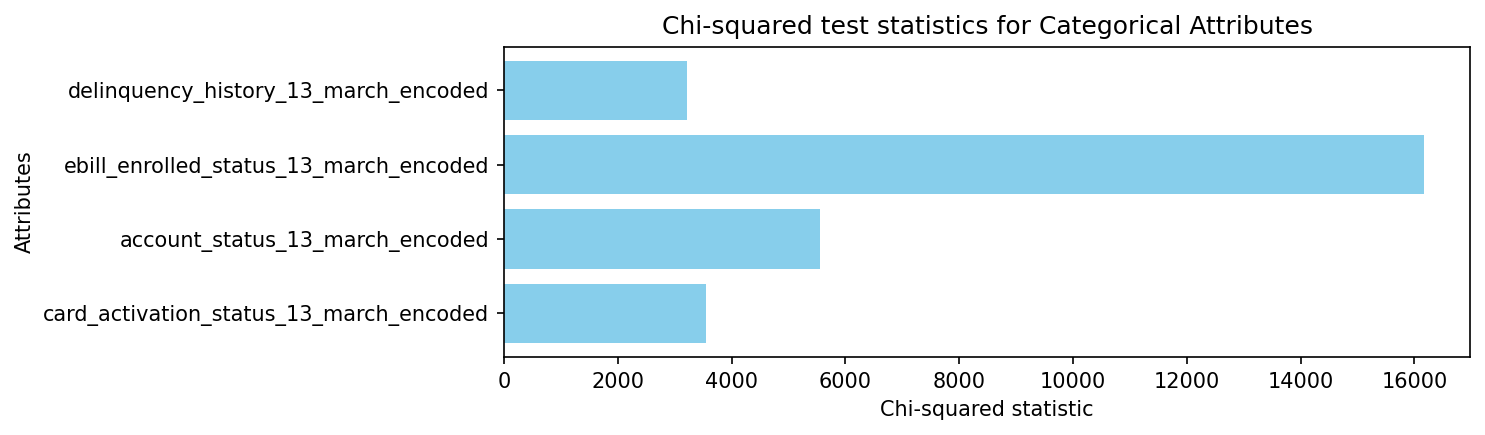

In [142]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.barh(list(chi2_results.keys()), [result['chi2'] for result in chi2_results.values()], color='skyblue')
ax.set_xlabel('Chi-squared statistic')
ax.set_ylabel('Attributes')
ax.set_title('Chi-squared test statistics for Categorical Attributes')
plt.tight_layout()
plt.show()

In [139]:
chi2_results

{'card_activation_status_13_march_encoded': {'chi2': 3550.502347356945,
  'p-value': 0.0},
 'account_status_13_march_encoded': {'chi2': 5550.144701882244,
  'p-value': 0.0},
 'ebill_enrolled_status_13_march_encoded': {'chi2': 16168.75647183686,
  'p-value': 0.0},
 'delinquency_history_13_march_encoded': {'chi2': 3211.77306049862,
  'p-value': 0.0}}

In [138]:
logreg_results = {}
for attribute in continuous_attributes:
    # Prepare the attribute and target variable for logistic regression
    X = data[[attribute]].fillna(0)  # Fill missing values with 0 for simplicity
    y = data['mos'].str.endswith('TR').astype(int)  # Binary outcome: transfer or not

    # Fit logistic regression model
    logreg = LogisticRegression()
    logreg.fit(X, y)

    # Store the coefficient and p-value (Wald's test)
    coef = logreg.coef_[0][0]
    intercept = logreg.intercept_[0]
    logreg_results[attribute] = {'coefficient': coef, 'intercept': intercept}

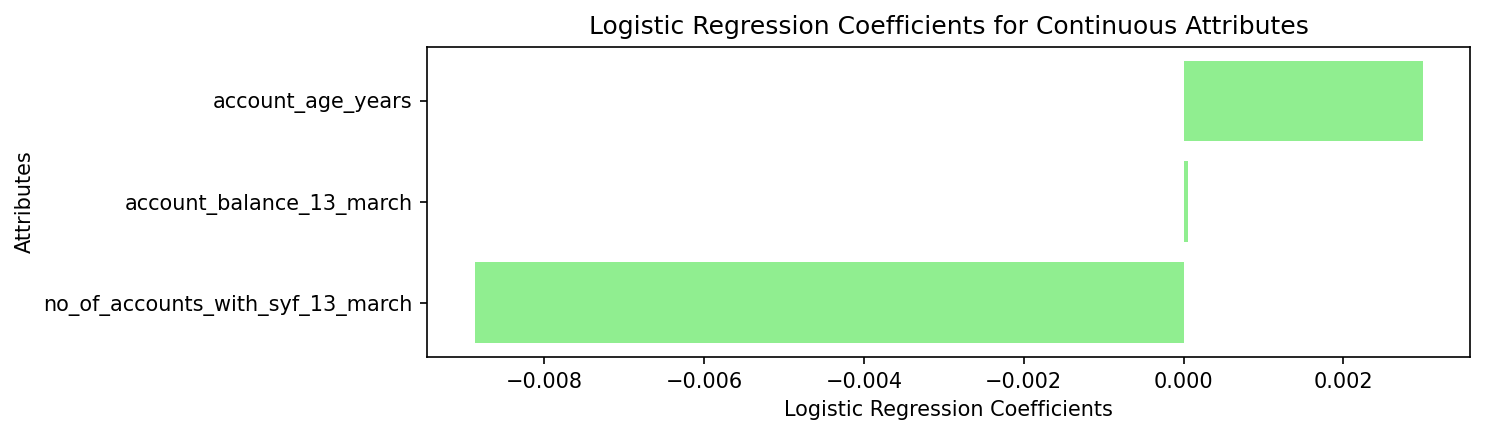

{'no_of_accounts_with_syf_13_march': {'coefficient': -0.008871424904363477,
  'intercept': 0.7479590150470027},
 'account_balance_13_march': {'coefficient': 5.876128814085534e-05,
  'intercept': 0.6339038536983295},
 'account_age_years': {'coefficient': 0.0029911385070487866,
  'intercept': 0.6877893331988304}}

In [141]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.barh(list(logreg_results.keys()), [result['coefficient'] for result in logreg_results.values()], color='lightgreen')
ax.set_xlabel('Logistic Regression Coefficients')
ax.set_ylabel('Attributes')
ax.set_title('Logistic Regression Coefficients for Continuous Attributes')
plt.tight_layout()
plt.show()

logreg_results

## **Root Cause Analysis**

<Figure size 4000x800 with 0 Axes>

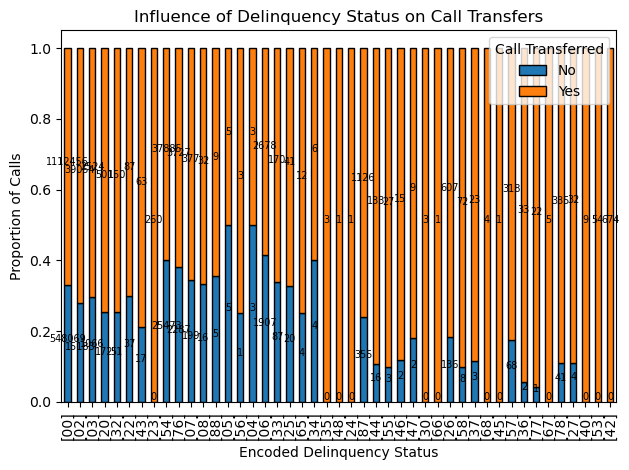

array(['[00]', '[02]', '[03]', '[20]', '[32]', '[22]', '[43]', '[23]',
       '[54]', '[76]', '[07]', '[08]', '[88]', '[05]', '[56]', '[04]',
       '[06]', '[33]', '[25]', '[65]', '[34]', '[35]', '[48]', '[24]',
       '[87]', '[44]', '[55]', '[46]', '[47]', '[30]', '[66]', '[26]',
       '[58]', '[37]', '[68]', '[45]', '[57]', '[36]', '[77]', '[67]',
       '[78]', '[27]', '[40]', '[53]', '[42]'], dtype=object)

In [191]:
# Create a crosstab of delinquency status with whether the call was transferred ('TR') or not.
delinquency_crosstab = pd.crosstab(index=data['delinquency_history_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
delinquency_crosstab_normalized = delinquency_crosstab.div(delinquency_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(20, 4), dpi=200)
delinquency_crosstab_normalized.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Influence of Delinquency Status on Call Transfers')
plt.xlabel('Encoded Delinquency Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Call Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(delinquency_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['delinquency_history_13_march'].unique())), labels=data['delinquency_history_13_march'].unique())
plt.tight_layout()
plt.show()

data['delinquency_history_13_march'].unique()


<Figure size 1200x800 with 0 Axes>

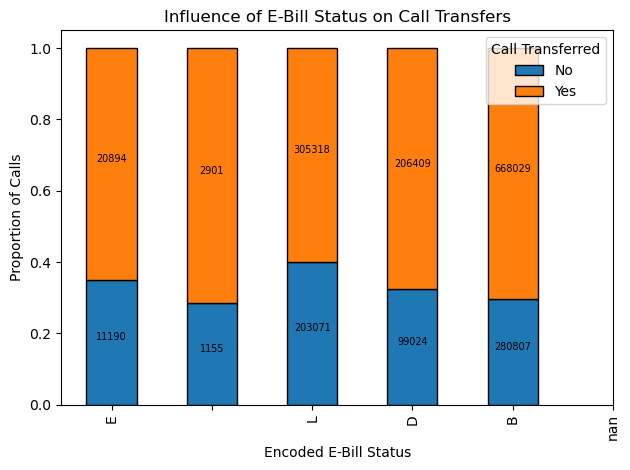

array(['E', ' ', 'L', 'D', 'B', nan], dtype=object)

In [190]:
ebill_crosstab = pd.crosstab(index=data['ebill_enrolled_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
ebill_crosstab_normalized = ebill_crosstab.div(ebill_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(6, 4), dpi=200)
ebill_crosstab_normalized.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Influence of E-Bill Status on Call Transfers')
plt.xlabel('Encoded E-Bill Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Call Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(ebill_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['ebill_enrolled_status_13_march'].unique())), labels=data['ebill_enrolled_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['ebill_enrolled_status_13_march'].unique()

<Figure size 1600x800 with 0 Axes>

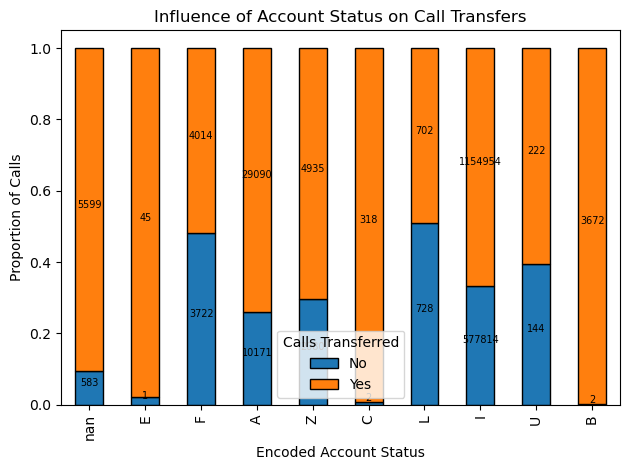

array([nan, 'E', 'F', 'A', 'Z', 'C', 'L', 'I', 'U', 'B'], dtype=object)

In [189]:
account_crosstab = pd.crosstab(index=data['account_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
account_crosstab_normalized = account_crosstab.div(account_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(8, 4), dpi=200)
account_crosstab_normalized.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Influence of Account Status on Call Transfers')
plt.xlabel('Encoded Account Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Calls Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(account_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['account_status_13_march'].unique())), labels=data['account_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['account_status_13_march'].unique()

<Figure size 1200x800 with 0 Axes>

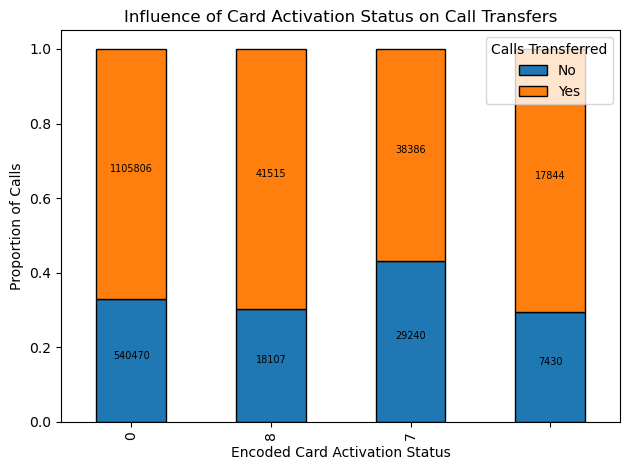

array(['0', '8', '7', ' '], dtype=object)

In [192]:
activation_crosstab = pd.crosstab(index=data['card_activation_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
activation_crosstab_normalized = activation_crosstab.div(activation_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(6, 4), dpi=200)
activation_crosstab_normalized.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Influence of Card Activation Status on Call Transfers')
plt.xlabel('Encoded Card Activation Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Calls Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(activation_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)

plt.xticks(ticks=range(len(data['card_activation_status_13_march'].unique())), labels=data['card_activation_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['card_activation_status_13_march'].unique()

## **Customer Journey Mapping**

In [230]:
transition_counts = defaultdict(int)
for sequence in TR_df['mos']:
    codes = sequence.split()  # Assuming codes in 'mos' are space-separated
    for i in range(len(codes) - 1):
        transition_counts[(codes[i], codes[i+1])] += 1

# Map the transitions to sources and targets for the Sankey diagram
sources = []
targets = []
values = []
labels = []
label_to_index = {}

# Assign an index to each unique code and fill sources, targets, and values
for (source, target), count in transition_counts.items():
    if source not in label_to_index:
        label_to_index[source] = len(labels)
        labels.append(source)
    if target not in label_to_index:
        label_to_index[target] = len(labels)
        labels.append(target)
    
    sources.append(label_to_index[source])
    targets.append(label_to_index[target])
    values.append(count)

In [231]:
palette = sns.color_palette("deep", 27)
hex_colors = palette.as_hex()

# Define the Sankey diagram with the generated color palette
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=5,  # Spacing between nodes
        thickness=1,  # Thickness of the nodes
        line=dict(color="black", width=0.5),  # Border line color and width
        label=labels,
        color=hex_colors  # Assign generated colors to the nodes
    ),
    link=dict(
        source=sources,  # Source node indices
        target=targets,  # Target node indices
        value=values,  # Volume of flow between nodes
        color=hex_colors  # Assign generated colors to the links
    )
)])

# Update layout for a better look and high resolution
fig.update_layout(
    title_text="Customer Journey Mapping through IVR leading to CS Transfer",
    font_size=16,  # Adjust font size
    width=2400,  # Width of the figure
    height=1200,  # Height of the figure
    paper_bgcolor='white',  # Background color of the figure
)

#visualize online as html
fig.write_html("Sankey.html")

In [233]:
sequences = data['mos'].str.split()
sequence_counts = Counter([tuple(sequence) for sequence in sequences])
top_sequences = sequence_counts.most_common(5)

sources, targets, values = [], [], []

# Map for sequence steps to node indices
node_map = {}
current_index = 0

for sequence, count in top_sequences:
    for i in range(len(sequence) - 1):
        # Check if the source node exists, if not add it
        if sequence[i] not in node_map:
            node_map[sequence[i]] = current_index
            current_index += 1
        # Check if the target node exists, if not add it
        if sequence[i+1] not in node_map:
            node_map[sequence[i+1]] = current_index
            current_index += 1
            
        sources.append(node_map[sequence[i]])
        targets.append(node_map[sequence[i+1]])
        values.append(count)

# Create labels from node_map
labels = list(node_map.keys())

palette = sns.color_palette("husl", len(labels))
hex_colors = palette.as_hex()

# Define the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=hex_colors  # Assign generated colors to the nodes
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=hex_colors  # Assign generated colors to the links
    )
)])

# Update layout for a better look
fig.update_layout(
    title_text="Top 5 Most Frequent Sequences in IVR Calls",
    font_size=14,
    width=800,
    height=600
)

# Show the figure
fig.show()
fig.write_html("Sankey_Top5.html")

## **Predictive Modeling**